In [2]:
; cd ..

/Users/alexlew/GenSP.jl/examples/typos


In [3]:
] activate ../..

  Activating project at `~/GenSP.jl`


In [4]:
using Revise
using Gen, GenSP, Random, StatsPlots, StatsBase
include("language_model.jl");
include("distributions/add_random_typo.jl");
include("distributions/guess_next_typo.jl");
include("distributions/dirac.jl");

┌ Info: Precompiling GenSP [4f04d0d6-512a-4468-8956-9155db99ad45]
└ @ Base loading.jl:1508


# Pseudomarginal SMC and MCMC with GenSP.jl

In this notebook, we will use GenSP.jl to implement a Bayesian spell-checker. The overall architecture is similar to [Peter Norvig's Bayesian spelling correction demo](https://norvig.com/spell-correct.html), with a *language model* $p(\mathbf{w})$ giving a prior over sentences $\mathbf{w} = (w_1, \dots, w_n)$, and a *likelihood* $p(\mathbf{y} \mid \mathbf{w}) = \prod_{i=1}^{n} p(y_i \mid w_i)$ that models the process by which an intended word is possibly misspelled. Our goal will then be to infer $p(\mathbf{w} \mid \mathbf{y})$, the posterior over true sentences, given the observed sentence. This notebook builds on Norvig's model in several ways:

1. Norvig considers correcting only single words, not sentences, so his language model is based on unigram frequencies; we use a Markov language model as our prior, so that nearby words can help disambiguate possible corrections.
2. Norvig's implementation does not use a probabilistic error model, instead relying on heuristics (assuming, e.g., that 2 typos are "infinitely less likely" than 1, and that the corrupted version of a word never happens to be another real word). We will instead use a error model defined by a probabilistic program.
3. In order to correct a whole sentence, we will compare two inference algorithms: sequential Monte Carlo (SMC) and Markov Chain Monte Carlo (MCMC). Because $p(y_i \mid w_i)$, the likelihood that a word $w_i$ is typed as $y_i$, is not analytically tractable in our model, we will need to estimate it. As a result, we will actually be implementing a *random-weight* particle filter and a *pseudomarginal* MCMC algorithm.

![alt text](./images/spelling_correction.png "Title")
<center>Mays et al.'s Bayesian approach to spelling correction.</center>

## 1) A model of typos

A key part of our spell-checker will be a generative model of typos. We consider a simple  model that repeatedly decides whether or not to add another typo (a random insertion, substitution, or deletion), before eventually returning a corrupted string.

In [99]:
# Observation model: given an intended word, how is it spelled?
@gen function typos_model(word)
    # Initialize a counter
    i = 1
    
    # Repeatedly decide whether to add a typo, or to leave the word be
    while (!({i => :leave_be} ~ bernoulli(0.95)))
        
        # If not leaving be, add a new typo 
        # (substitution, insertion, or deletion)
        # and increment the counter.
        word = {i => :typo} ~ add_random_typo(word)
        i += 1
    end
    
    # Create a `corrupted` address in the trace that holds
    # the final corrupted word.
    corrupted ~ dirac(word)
    return corrupted
end;

Recall that in Gen, the expression `{address_expr} ~ distribution(args)` samples from the given distribution, and traces the result at the address `address_expr`. The syntax `var ~ distribution(args)` is sugar for `var = {:var} ~ distribution(args)`. The syntax `a => b` constructs a Julia pair of `a` and `b`; we use it in Gen to represent hierarchical addresses for random choices.

We can run the model to transform a string, or use Gen's `simulate` method to obtain a trace:

In [133]:
Random.seed!(19) # for repeatable results

typos_model("probabilistic")

"probabili2tisc"

In [7]:
Random.seed!(19)

trace = simulate(typos_model, ("probabilistic",))
get_choices(trace)

│
├── :corrupted : probabili2tisc
│
├── 2
│   │
│   ├── :typo : probabili2tisc
│   │
│   └── :leave_be : false
│
├── 3
│   │
│   └── :leave_be : true
│
└── 1
    │
    ├── :typo : probabili2tic
    │
    └── :leave_be : false


We can see that the output "probabili2tisc" was generated by performing two typos before eventually deciding to leave the word be. 

### 1.1) Marginalizing the typos distribution

Although we have implemented a model of typos, we cannot easily evaluate the *marginal* density of the model, i.e., the probability that a particular input word is transformed into a particular output word. 

However, we can *estimate* the program's marginal density. GenSP.jl exposes a `Marginal` operator for constructing a new primitive distribution as the marginal of an existing generative function. The operator takes as input:
* A generative function to marginalize
* An inference algorithm to use for marginalization
* The trace address of the choice whose marginal distribution is desired

In [153]:
# Create a new primitive distribution `corrupt` representing the marginal
# of the trace address `:corrupted` in `typos_model`. Use 1e6-particle importance
# sampling to estimate marginal densities.
corrupt = Marginal{String}(typos_model, importance(1e6), :corrupted);

What we get out is a new primitive distribution. Its traces contain only the sampled value, nothing else:

In [154]:
Random.seed!(51) 

print(get_choices(simulate(corrupt, ("probabilistic",))))

ValueChoiceMap{String}("probabilisti")

Furthermore, the score of a trace is now an estimate of the *marginal* probability of the returned value, rather than the *joint* probability of all the choices used to generate it.

In [156]:
# Joint density: probability of a *particular* path
Random.seed!(51); 

get_score(simulate(typos_model, ("probabilistic",)))

-6.710587214071186

In [157]:
# Marginal density: estimated probability summing over *all* paths
Random.seed!(51); 

get_score(simulate(corrupt, ("probabilistic",)))

-6.738856742520323

We can use our new `Distribution` to make primitive random choices within a larger generative function.

In [24]:
# For the next example, define a distribution for sampling uniformly from a list
@dist uniform_from_list(lst) = lst[uniform_discrete(1, length(lst))] 

# Define a little model using `corrupt` as a likelihood.
@gen function example()
    true_word  ~ uniform_from_list(["probabilistic", "program", "example"])
    typed_word ~ corrupt(true_word)
end;

# Traces of the model hide all the marginalized choices
Random.seed!(3)

get_choices(simulate(example, ()))

│
├── :typed_word : )rogram
│
└── :true_word : program


We can use `assess` to get the probability $p(w, y)$ of a particular true word $w$ being chosen, and then being corrupted as an observed word $y$.

In [33]:
# We can ask for the density of `example` at a particular (true_word, typed_word) pair.
# This is a *marginal* density, marginalizing over all the choices made while introducing
# typos. It is just an unbiased estimate, so values may vary from run to run.
assess(example, (), choicemap(:true_word => "probabilistic", :typed_word => "probabilisti"))

(-7.774462510667464, "probabilisti")

The `assess` method can also be used directly on `corrupt` to evaluate arbitrary marginal corruption probabilities.

In [159]:
# we can also directly estimate densities of the `corrupt` distribution:
# distributions are ordinary generative functions, but produce atomic 
# ValueChoiceMaps, which store a single value (without any addresses).
assess(corrupt, ("probabilistic",), ValueChoiceMap("probabilisti"))

(-6.717961707349481, "probabilisti")

### 1.2) Speeding up density estimation with custom inference

These estimates are produced by using the algorithm `importance(1e6)` to infer typo paths that could plausibly lead to the observed typo. This is a very inefficient algorithm. We can use many fewer particles if we use a smarter proposal distribution:

In [160]:
@gen function typos_proposal(target)
    # The proposal receives as input a `Target`,
    # which stores a model generative function
    # (typos_model), arguments to the model, and
    # a choicemap of observations.
    word,     = target.args
    corrupted = target.constraints[:corrupted]

    # Keep proposing typos until arriving at the observation
    i = 1
    while (!({i => :leave_be} ~ bernoulli(word==corrupted ? 0.995 : 0.0)))
        
        # propose next typo in a 'smart' way based on the corrupted word
        word = {i => :typo} ~ guess_next_typo(word, corrupted)
        i += 1
    end
end


# Use custom_importance instead of importance, to incorporate the new proposal.
proposal_distribution = ChoiceMapDistribution(typos_proposal)

corrupt = Marginal{String}(typos_model, 
                           custom_importance(proposal_distribution, 10), 
                           :corrupted);

This makes estimation much faster, and allows for accurate estimates even for very unlikely observations under the prior.

In [173]:
assess(corrupt, ("probabilistic",), ValueChoiceMap("prblistic"))

(-20.840014479632288, "prblistic")

In [180]:
Random.seed!(51); get_score(simulate(corrupt, ("probabilistic",)))

-6.801119010851546

In [187]:
assess(corrupt, ("probabilistic",), ValueChoiceMap("probabilisti"))

(-6.695783303118364, "probabilisti")

### 1.3) Inference Algorithms are `Distribution{ChoiceMap}`s that Approximate Posteriors

We have now seen `importance` and `custom_importance`, which construct _inference algorithms_ that can be passed to `Marginal`. These are just two of many such methods GenSP provides.

But what are these inference algorithm objects?

In fact, **inference algorithms in Prox are actually Prox distributions themselves**, that take a `Target` as input, and approximate its posterior over ChoiceMaps. This may sound familiar, as this was also the type of our custom proposal, `proposal_distribution`. **Both custom proposals and inference algorithms are approximate representations of posteriors; they have the same type and can be used interchangeably in GenSP.**

To understand this concept better, let's consider the million-particle importance sampling method we invoked earlier:

In [188]:
importance_1e6 = importance(1e6)

GenSP.DefaultImportance(1000000)

As an inference method, it accepts as arguments a *target*, which combines a model, arguments, and constraints.

In [189]:
# A Target is a model, its arguments, and a set of constraints or observations.
target = Target(typos_model, ("probabilistic",), choicemap(:corrupted => "probablistic"));

We can run `importance_1e6` on `target`, and extract its return value: an approximate posterior ChoiceMap.

In [190]:
# Simulate from an approximation to the posterior.
# The *return value* of importance_1e6 is a ChoiceMap 
# containing the inferred latent variables from typos_model.
get_retval(Gen.simulate(importance_1e6, (target,)))

│
├── 2
│   │
│   └── :leave_be : true
│
└── 1
    │
    ├── :typo : probablistic
    │
    └── :leave_be : false


_Note that we have called `get_retval` here, and not `get_choices`. Like a normal or Bernoulli distribution, `importance_1e6` does not expose "internal choices": it monolithically returns a value. Although the value it returns happens to be a hierarchical ChoiceMap, it returns it monolithically, so, for example, it is not possible to use `generate` on `importance_1e6` to partially constrain its results._

The custom proposal we wrote earlier, `proposal_distribution`, has the same type (`Distribution{ChoiceMap}` parameterized by a `Target`), so we can run the exact same line of code using *it* as the posterior approximation:

In [193]:
# Simulate from our proposal.
get_retval(Gen.simulate(proposal_distribution, (target,)))

│
├── 2
│   │
│   └── :leave_be : true
│
└── 1
    │
    ├── :typo : probablistic
    │
    └── :leave_be : false


Or we can construct the 10-particle IS algorithm that uses `proposal_distribution` as a proposal, and simulate from it:

In [196]:
# Simulate from a faster approximation to the posterior.
better_inference = custom_importance(proposal_distribution, 10)
get_retval(Gen.simulate(better_inference, (target,)))

│
├── 2
│   │
│   └── :leave_be : true
│
└── 1
    │
    ├── :typo : probablistic
    │
    └── :leave_be : false


This inference algorithm is fast enough and accurate enough to solve harder posterior inference problems, where the posterior concentrates on long typo paths:

In [203]:
# A harder target, with longer typo paths necessary to explain the observation
target = Target(typos_model, ("probabilistic",), choicemap(:corrupted => "professional"))
get_retval(Gen.simulate(better_inference, (target,)))

│
├── 5
│   │
│   ├── :typo : probebisiotal
│   │
│   └── :leave_be : false
│
├── 4
│   │
│   ├── :typo : probebisistal
│   │
│   └── :leave_be : false
│
├── 6
│   │
│   ├── :typo : probeisiotal
│   │
│   └── :leave_be : false
│
├── 7
│   │
│   ├── :typo : profeisiotal
│   │
│   └── :leave_be : false
│
├── 2
│   │
│   ├── :typo : probebisistic
│   │
│   └── :leave_be : false
│
├── 10
│   │
│   └── :leave_be : true
│
├── 9
│   │
│   ├── :typo : professional
│   │
│   └── :leave_be : false
│
├── 8
│   │
│   ├── :typo : profeisional
│   │
│   └── :leave_be : false
│
├── 3
│   │
│   ├── :typo : probebisistil
│   │
│   └── :leave_be : false
│
└── 1
    │
    ├── :typo : probebilistic
    │
    └── :leave_be : false


### 1.4) As Distributions, Inference Processes Can Report Their Own Marginal Densities

**Because GenSP's inference algorithms are themselves Distributions (over ChoiceMaps), they can estimate their own densities.** 

For example, consider a target where the posterior is highly concentrated.

In [204]:
target = Target(typos_model, ("probabilistic",), choicemap(:corrupted => "probablistic"));

Here, we expect the posterior to concentrate nearly all its mass on
a single explanation of how "probabilistic" was mangled to become "probablistic":
the 'i' between the 'b' and the 'l' was deleted.

In [205]:
# Modal typo path: a single typo deleting the 'i' between 'b' and 'l'.
Random.seed!(1)
modal_typo_path = get_retval(Gen.simulate(better_inference, (target,)));

As such, we would expect the **posterior density** of this particular typo path to be very close to 1. We can use `assess` to compute estimates of this density, and plot them:

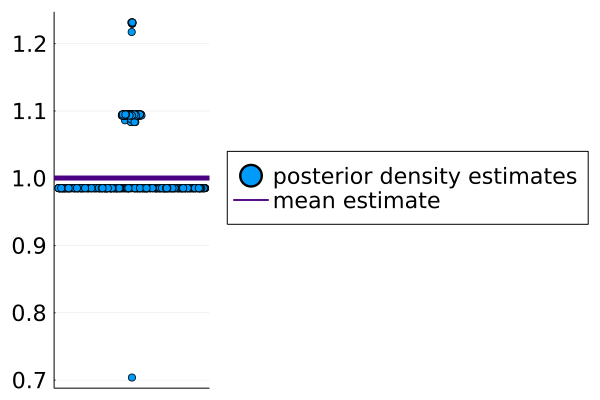

In [83]:
# Obtain and plot 1000 independent estimates of the density of the typo path, under
# our approximate posterior
logprob_estimates = [Gen.assess(better_inference, 
                                (target,), 
                                ValueChoiceMap(modal_typo_path))[1]
                     for _ in 1:1000]

# Plot them
dotplot(ones(1000), exp.(logprob_estimates), label="posterior density estimates", legend=:outerright, legendfontsize=15, tickfontsize=15, xticks=nothing)
plot!([mean(exp.(logprob_estimates))]; linetype=:hline, color="indigo",label="mean estimate", linewidth=5)

But now consider a target where the posterior is more diffuse: there are many possible typo paths could lead from "probabilistic" to "profession".

In [208]:
target = Target(typos_model, ("probabilistic",), choicemap(:corrupted => "professional"));

Let's consider one of the many possible typo paths:

In [209]:
# Generate a possible typo path:
some_typo_path = get_retval(Gen.simulate(better_inference, (target,)))

│
├── 5
│   │
│   ├── :typo : profeilionic
│   │
│   └── :leave_be : false
│
├── 4
│   │
│   ├── :typo : profeilisnic
│   │
│   └── :leave_be : false
│
├── 6
│   │
│   ├── :typo : profeisionic
│   │
│   └── :leave_be : false
│
├── 7
│   │
│   ├── :typo : profeisionil
│   │
│   └── :leave_be : false
│
├── 2
│   │
│   ├── :typo : profbilistic
│   │
│   └── :leave_be : false
│
├── 10
│   │
│   └── :leave_be : true
│
├── 9
│   │
│   ├── :typo : professional
│   │
│   └── :leave_be : false
│
├── 8
│   │
│   ├── :typo : professionil
│   │
│   └── :leave_be : false
│
├── 3
│   │
│   ├── :typo : profbilisnic
│   │
│   └── :leave_be : false
│
└── 1
    │
    ├── :typo : probbilistic
    │
    └── :leave_be : false


What is its posterior probability? Because there are so many possible paths, the posterior probability should be very low.

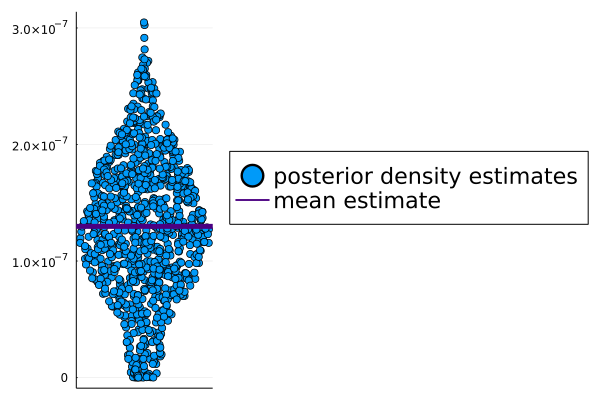

In [86]:
# Obtain 1000 independent estimates of the density of the typo path, under
# our approximate posterior
logprob_estimates = [Gen.assess(better_inference, 
                                (target,), 
                                ValueChoiceMap(some_typo_path))[1] for _ in 1:1000]

# Plot them
dotplot(ones(1000), exp.(logprob_estimates), label="posterior density estimates", legend=:outerright, legendfontsize=15, ticksize=15, xticks=nothing)
plot!([mean(exp.(logprob_estimates))]; linetype=:hline, color="indigo",label="mean estimate", linewidth=5)

Note these are *not* the marginal densities we were looking at earlier: they are (estimated) densities of the *approximate posterior* that our importance sampler yields. 

However, they can be *used* to generate marginal likelihood estimates: in order to estimate a density, `Marginal` draws an approximate posterior sample from the inference algorithm, and computes `p(trace) / inference_alg(trace)`. Essentially, we are using the inference algorithm as an especially powerful importance sampling proposal.

_(To hit this point home, note that `custom_importance(proposal, 1)` is equivalent to just using `proposal`, even when `proposal` is another inference algorithm (e.g., `custom_importance(importance(1e6), 1)`). If we write `custom_importance(better_inference, 100)`, we get an algorithm that does 100 replicates of 10-particle importance sampling using our `proposal_distribution`, which is not quite the same as `custom_importance(proposal_distribution, 1000)`.)_

### 1.5) Recap So Far

We have seen so far that:

1. **Custom proposal distributions and other inference processes are represented as `Distribution{ChoiceMap}` objects**, reflecting that they encode distributions over ChoiceMaps but not necessarily ones that can be factored cleanly or intervened on (like GenerativeFunctions can).

2. An inference process represented as a `Distribution{ChoiceMap}` accepts as an argument a `Target`, which specifies a generative function `p`, arguments `args`, and observations `constraints`. The goal of the inference process is to sample from the posterior represented by that `Target`.

3. These `Distribution{ChoiceMap}`s can be created in several ways:
* Writing a generative function that directly infers latents, then using the `ChoiceMapDistribution` combinator on it.
* Using methods from the inference library, like `importance` and `custom_importance`.

4. The `Marginal` construct can be used to build new Distributions over arbitrary types, by providing a generative function, an inference method for marginalization, and an address to project out of the generative function's ChoiceMap.


## 2) Using the model for spelling correction

In order to define a prior over *correctly spelled* English sentences, we 
imported a bigram language model at the top of this file. Using it, we can
define our overall model over true words. We use Gen's `Unfold` combinator
to easily define a Markov model, given a generative function defining a transition
kernel.

In [210]:
@gen (static) function next_word(i, previous_word)
   word  ~ gen_word(previous_word) 
   typed ~ corrupt(word)
   return word
end;

model = Unfold(next_word);

Traces of `model` record a sequence of true and typed words:

In [211]:
Random.seed!(31)
get_choices(simulate(model, (8, "<start>")))

│
├── 1
│   │
│   ├── :word : some
│   │
│   └── :typed : some
│
├── 2
│   │
│   ├── :word : red
│   │
│   └── :typed : red
│
├── 3
│   │
│   ├── :word : herring
│   │
│   └── :typed : he;rring
│
├── 4
│   │
│   ├── :word : for
│   │
│   └── :typed : for
│
├── 5
│   │
│   ├── :word : weeks
│   │
│   └── :typed : weeks
│
├── 6
│   │
│   ├── :word : .
│   │
│   └── :typed : .
│
├── 7
│   │
│   ├── :word : our
│   │
│   └── :typed : ou9
│
└── 8
    │
    ├── :word : offer
    │
    └── :typed : offer


Note that much of the time the word is typed correctly, but "herring" has been converted to "he;rring" and "our" to "ou9". 

Let's consider *correcting* the following mangled sentence: "i kni that yuo think taht i m jad"

In [212]:
sentence = "i kni that yuo think taht i m jad"
constraints = choicemap([(i => :typed) => word for (i, word) in enumerate(split(sentence))]...)
target = Target(model, (9, "<start>"), constraints);

### 2.1) Pseudomarginal MH

Let's begin with a Metropolis-Hastings algorithm.

We will use *random-scan* *resimulation MH*: after generating an initial trace, we will run many iterations of the following kernel:

* Randomly select an index $j \in \{1, \dots, |\mathbf{w}|\}$
* Randomly repropose $w_j$, and accept or reject.

To perform the second step, we use Gen's `mh` function.

In [213]:
# Generate an initial trace
initial_trace = GenSP.generate(target, choicemap());
scores, hypotheses = Float64[], String[]

# Run MH
for iter in 1:10000
    j = uniform_discrete(1, 9)
    initial_trace, acc = mh(initial_trace, select(j => :word))
    push!(scores, get_score(initial_trace))

    if iter > 2500
        push!(hypotheses, join([initial_trace[i => :word] for i in 1:9], " "))
    end
end;

StatsBase.countmap(hypotheses)

Dict{String, Int64} with 6 entries:
  "i know that you think that i am glad" => 685
  "i know that you think that i 'm dead" => 291
  "i knew that you think that i 'm glad" => 1305
  "i know that you think that i am dead" => 83
  "i know that you think that i 'm glad" => 5061
  "i knew that you think that i 'm dead" => 75

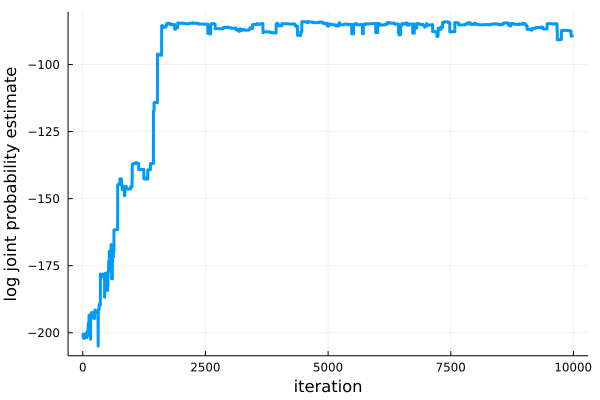

In [214]:
plot(scores, linewidth=3, ylabel="log joint probability estimate", xlabel="iteration", label=nothing)

Although we used Gen's `mh` function here, we can also use Prox's inference library, so that the resulting inference algorithm is itself a `Distribution`. 

To do so, we first express our kernel in Gen's kernel DSL:

In [215]:
@kern function my_kernel(trace)
    
    for rep in 1:10000
      let j ~ uniform_discrete(1, 9)
          trace ~ mh(trace, select(j => :word))
      end
    end
end;

Then pass the kernel to Prox's `mcmc` method, along with a method for generating the initial trace:

In [216]:
pseudomarg = GenSP.mcmc(importance(1), my_kernel, ()); # last arg is any additional kernel arguments

In [217]:
get_retval(simulate(pseudomarg, (target,)))

│
├── 5
│   │
│   └── :word : think
│
├── 4
│   │
│   └── :word : you
│
├── 6
│   │
│   └── :word : that
│
├── 7
│   │
│   └── :word : i
│
├── 2
│   │
│   └── :word : know
│
├── 9
│   │
│   └── :word : glad
│
├── 8
│   │
│   └── :word : 'm
│
├── 3
│   │
│   └── :word : that
│
└── 1
    │
    └── :word : i


However, by default the strategy used by GenSP's `mcmc` method to estimate posterior probabilities is quite poor (unbiased but very high-variance). If it is important to have accurate posterior probability estimates, consider chaining multiple calls to `mcmc` together with an annealed sequence of targets, or using a more complex meta-inference scheme as described in our UAI paper, "Recursive Monte Carlo and Variational Inference with Auxiliary Variables."

### 2.2) Random-Weight SMC

We may have more luck trying a *Sequential Monte Carlo* algorithm, that exploits the sequential nature of the inference problem. One option is to use Gen's particle filtering functions with our model:

In [218]:
# Initialize with no words
state = Gen.initialize_particle_filter(model, (0, "<start>"), choicemap(), 1000);

NUM_WORDS = 9

# For each word in the observed sentence...
for (i, word) in enumerate(split(sentence)[1:NUM_WORDS])
    # Advance the particles
    Gen.particle_filter_step!(state, (i, "<start>"), 
        (UnknownChange(), NoChange()), 
        choicemap((i => :typed) => word))
    
    # Perform a resampling step
    maybe_resample!(state)
    
    # Report the results so far
    display(StatsBase.countmap([join([trace[j => :word] for j in 1:i], " ") for trace in sample_unweighted_traces(state, 1000)]))
end
#StatsBase.countmap([join([trace[i => :word] for i in 1:NUM_WORDS], " ") for trace in sample_unweighted_traces(state, 1000)])

Dict{String, Int64} with 4 entries:
  ","  => 1
  "is" => 2
  "."  => 2
  "i"  => 995

Dict{String, Int64} with 3 entries:
  "i knew" => 88
  "i know" => 900
  "i kind" => 12

Dict{String, Int64} with 2 entries:
  "i knew that" => 124
  "i know that" => 876

Dict{String, Int64} with 6 entries:
  "i knew that you"  => 64
  "i know that your" => 13
  "i know that you"  => 915
  "i knew that your" => 4
  "i know that to"   => 2
  "i know that no"   => 2

Dict{String, Int64} with 1 entry:
  "i know that you think" => 1000

Dict{String, Int64} with 1 entry:
  "i know that you think that" => 1000

Dict{String, Int64} with 3 entries:
  "i know that you think that in" => 1
  "i know that you think that i"  => 998
  "i know that you think that is" => 1

Dict{String, Int64} with 4 entries:
  "i know that you think that i ,"  => 1
  "i know that you think that i am" => 81
  "i know that you think that i 'm" => 917
  "i know that you think that i ?"  => 1

Dict{String, Int64} with 6 entries:
  "i know that you think that i 'm dead"  => 13
  "i know that you think that i 'm a"     => 4
  "i know that you think that i 'm sad"   => 415
  "i know that you think that i 'm ready" => 1
  "i know that you think that i 'm glad"  => 113
  "i know that you think that i 'm bad"   => 454

Again, the same algorithm can be expressed in Prox, using Prox's SMC commands, if the goal is to represent the posterior *as* a Distribution.

In [219]:
@gen function smc_proposal(particle, new_target)
  i = length(get_retval(particle))
  {i+1 => :word} ~ gen_word(i == 0 ? "<start>" : last(get_retval(particle)))
end


my_smc_alg = GenSP.SMCInit(importance(1), Target(model, (0, "<start>"), choicemap()), 1000);
for (i, word) in enumerate(split(sentence)[1:9])
    # Advance the particles
    my_smc_alg = GenSP.ExtendingSMCStep(my_smc_alg, ChoiceMapDistribution(smc_proposal), 
      (i, "<start>"), (UnknownChange(), NoChange()), choicemap((i => :typed) => word))
    
    # Perform a resampling step, with ESS threshold 0.2 and 1000 particles.
    my_smc_alg = GenSP.SMCResample(my_smc_alg, 0.2, 1000)
end

In [220]:
tr = simulate(my_smc_alg, (target,))
get_retval(tr)

│
├── 5
│   │
│   └── :word : think
│
├── 4
│   │
│   └── :word : you
│
├── 6
│   │
│   └── :word : that
│
├── 7
│   │
│   └── :word : i
│
├── 2
│   │
│   └── :word : knew
│
├── 9
│   │
│   └── :word : glad
│
├── 8
│   │
│   └── :word : 'm
│
├── 3
│   │
│   └── :word : that
│
└── 1
    │
    └── :word : i
